In [2]:
import sys
sys.path.append('..//')

import jax
import numpy as np
import jax.numpy as jnp
import scipy
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pandas as pd

jax.config.update("jax_enable_x64", True)

from parsmooth._base import MVNStandard, FunctionalModel, MVNSqrt
from parsmooth.linearization import extended
from parsmooth.methods import iterated_smoothing
from bearing_data_pe import get_data, make_parameters, inverse_bearings


In [1]:
linearization_method = extended

s1 = jnp.array([-1., 0.5])  # First sensor location
s2 = jnp.array([1., 1.])  # Second sensor location
x0 = jnp.array([0.1, 0.2, 1, 0])  # initial true location
dt = 0.01  # discretization time step
qc = 0.1  # discretization noise
qw = 0.1  # discretization noise

r_true = 0.05
T = 50
_, true_states, ys = get_data(x0, dt, r_true, T, s1, s2)
Q, _, observation_function, transition_function = make_parameters(qc, qw, r_true, dt, s1, s2)

chol_Q = jnp.linalg.cholesky(Q)

m0 = jnp.array([2., 0, 0, 0, 0])
P0 = jnp.diag(jnp.array([0.5**2, 0.5**2, 0.5**2, 0.5**2, 1.]))
chol_P0 = scipy.linalg.cholesky(P0)

init = MVNStandard(m0, P0)
chol_init = MVNSqrt(m0, chol_P0)


positions = inverse_bearings(ys, s1, s2)
states = jnp.concatenate([jnp.concatenate([jnp.zeros((1,2)), positions], axis = 0), 
                          jnp.zeros((T+1,3))], axis = 1)

initial_states =  MVNStandard(states,jnp.repeat(jnp.eye(5).reshape(1, 5, 5), T + 1, axis=0))
initial_states_sqrt = MVNSqrt(states,jnp.repeat(jnp.eye(5).reshape(1, 5, 5), T + 1, axis=0))


sqrt_transition_model = FunctionalModel(transition_function, MVNSqrt(jnp.zeros((5,)), chol_Q))
transition_model = FunctionalModel(transition_function, MVNStandard(jnp.zeros((5,)), Q))


In [3]:
#standard
@jax.jit
def get_ell_std(prec_r):
    r = 1 / prec_r[0]
    R = jnp.diag(jnp.array([r ** 2, 0.1 ** 2]))
    observation_model = FunctionalModel(observation_function, MVNStandard(jnp.zeros((2,)), R))  
    
    _, ell = iterated_smoothing(ys, init, transition_model, observation_model,
                                               linearization_method, initial_states, True,
                                               criterion=lambda i, *_: i < 50,
                                               return_loglikelihood = True)
    return -ell

grad_ell_std = jax.jit(jax.value_and_grad(get_ell_std))

In [4]:
gpu_grad_ell_std = jax.jit(grad_ell_std, backend="gpu")



In [2]:
def wrap_func_std(r):
    loss, grad_val = gpu_grad_ell_std(r)
    return np.array(loss, dtype=np.float64), np.array(grad_val, dtype=np.float64)
r0 = np.array([10.])
minimize(wrap_func_std, r0, jac=True, method="L-BFGS-B", bounds=[(0, 100)])


In [6]:
#square-root
@jax.jit
def get_ell_sqrt(prec_r):
    r = 1 / prec_r[0]
    chol_R = jnp.diag(jnp.array([r, 0.1]))
    observation_model_sqrt = FunctionalModel(observation_function, MVNSqrt(jnp.zeros((2,)), chol_R)) 
    
    _, ell = iterated_smoothing(ys, chol_init, sqrt_transition_model, observation_model_sqrt,
                                               linearization_method, initial_states_sqrt, True,
                                               criterion=lambda i, *_: i < 50,
                                               return_loglikelihood = True)
    return -ell

grad_ell_sqrt = jax.jit(jax.value_and_grad(get_ell_sqrt))


In [7]:
gpu_grad_ell_sqrt = jax.jit(grad_ell_sqrt, backend="gpu")

In [3]:
def wrap_func_sqrt(r):
    loss, grad_val = gpu_grad_ell_sqrt(r)
    return np.array(loss, dtype=np.float64), np.array(grad_val, dtype=np.float64)
r0 = np.array([10.])
minimize(wrap_func_sqrt, r0, jac=True, method="L-BFGS-B", bounds=[(0, 100)])


In [2]:
with np.load("pe_ell_std_extended_T50_par.npz") as loaded:
    ell_std_extended_T50_par = loaded["ell_std_extended_T50_par"]
    grad_ell_std_extended_T50_par = loaded["grad_ell_std_extended_T50_par"]
    theta_par_std = loaded["theta_par_std"]
    
with np.load("pe_ell_sqrt_extended_T50_par.npz") as loaded:
    ell_sqrt_extended_T50_par = loaded["ell_sqrt_extended_T50_par"]
    grad_ell_sqrt_extended_T50_par = loaded["grad_ell_sqrt_extended_T50_par"]
    theta_par_sqrt = loaded["theta_par_sqrt"]



[0.04934241]
[0.04934242]


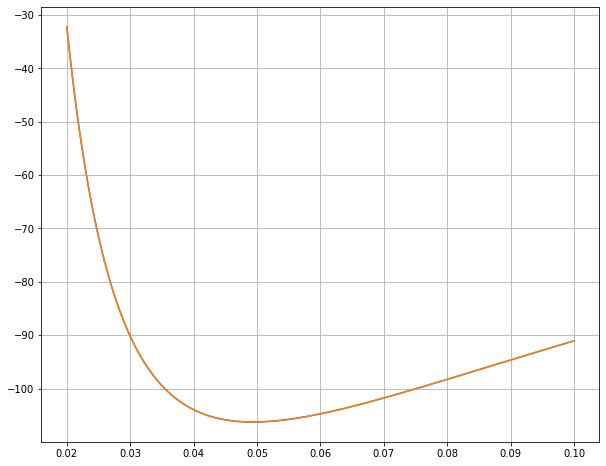

In [3]:
plt.figure(figsize=(10,8))
plt.plot(np.flip(1/np.linspace(10, 50)),np.flip(ell_std_extended_T50_par))
plt.plot(np.flip(1/np.linspace(10, 50)),np.flip(ell_sqrt_extended_T50_par))
plt.grid()

print(theta_par_std)
print(theta_par_sqrt)



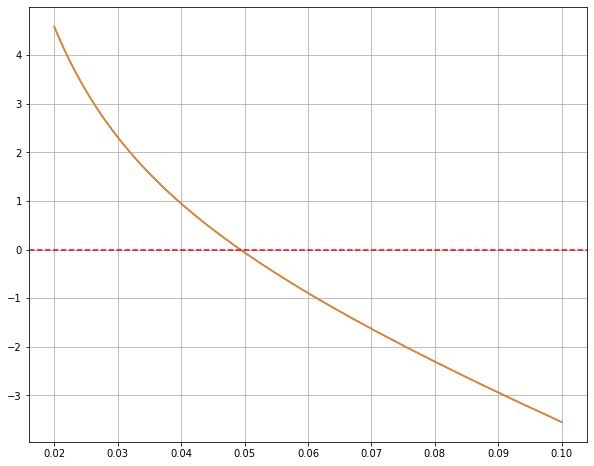

In [4]:
plt.figure(figsize=(10,8))
plt.plot(np.flip(1/np.linspace(10, 50)),np.flip(grad_ell_std_extended_T50_par))
plt.plot(np.flip(1/np.linspace(10, 50)),np.flip(grad_ell_sqrt_extended_T50_par))
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.grid()

In [12]:
data = np.stack([np.flip(1/np.linspace(10, 50)),
                 np.flip(ell_std_extended_T50_par),
                 np.flip(ell_sqrt_extended_T50_par),
                 np.flip(grad_ell_std_extended_T50_par[:,0]),
                 np.flip(grad_ell_sqrt_extended_T50_par)[:,0]],
                 axis=1)

columns = ["ell",
           "ell_std_extended_par",
           "ell_sqrt_extended_par",
           "grad_ell_std_extended_par",
           "grad_ell_sqrt_extended_par"]

df = pd.DataFrame(data=data, columns=columns)
df.to_csv("outputs/pe_extended_ell_par.csv")